# Pub accessibility for Inner London

## Data and preparation

> Pubs (data provided by CAMRA in January 2019)
> https://data.london.gov.uk/download/cultural-infrastructure-map/7e6b0f36-da01-4029-99d7-640d89c4a0a4/Pubs.csv
> Buildings defined by CAMRA as pubs. Licensed premises must be open to and welcome the general public without requiring membership or residency, allow free entry (1), serve at least one draught beer (2), allow drinking without requiring food to be consumed, have at least one indoor area not laid out for meals, and permit drinks to be purchased in person at a bar (3), without relying on table service.’ (1) Except when entertainment is provided on limited occasions (2) Includes cask or keg beer (3) Includes also a hatch or specific service point’
> How data was compiled: Data provided by the Campaign for Real Ale.
> Credit for use: The Campaign for Real Ale

This examples calculates landuse accessibility to pubs for inner London.

For additional information on network preparation, see the corresponding notebook on [graph cleaning](https://colab.research.google.com/github/cityseer/cityseer/blob/master/demos/graph_cleaning.ipynb).

This example will make use of OSM data downloaded from the [OSM API](https://wiki.openstreetmap.org/wiki/API) for a 5000m radius around London Soho.

`matplotlib` magic command (only necessary for `jupyter` notebooks). 

Install and update `cityseer` if necessary.

In [ ]:
%matplotlib inline
!pip install --upgrade cityseer

In [1]:
%matplotlib inline
%pip install cityseer
%pip install pyproj

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyproj import CRS, Transformer
from shapely import geometry
import utm

# starting point
lng, lat = -0.13396079424572427, 51.51371088849723
distance = 5000
easting, northing, utm_zone_number, utm_zone_letter = utm.from_latlon(lat, lng)
centre = geometry.Point(easting, northing)
# CRS transformations
crs_utm = CRS.from_dict({"proj": "utm", "zone": utm_zone_number, "south": False})
crs_bng = CRS.from_epsg(27700)
crs_transformer = Transformer.from_crs(crs_bng, crs_utm, always_xy=True)

In [3]:
# prepare network from OSM
from cityseer.tools import graphs, mock
from cityseer.metrics import networks

# download from OSM - see docs if you want examples for how to use osmNx for this step
G_utm = mock.make_buffered_osm_graph(lng, lat, distance)
# simplify - this is not necessary if using "clean" graph sources - e.g. OS Open Roads
G = graphs.nx_simple_geoms(G_utm)
G = graphs.nx_remove_filler_nodes(G)
G = graphs.nx_remove_dangling_nodes(G, despine=20, remove_disconnected=True)
G = graphs.nx_remove_filler_nodes(G)
G1 = graphs.nx_consolidate_nodes(G, buffer_dist=10, min_node_group=3)
G2 = graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = graphs.nx_consolidate_nodes(G2, buffer_dist=15, crawl=False, min_node_degree=2, cent_min_degree=4)
# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G3, 25)
# create a cityseer network layer
N = networks.NetworkLayerFromNX(G_decomp, distances=[100, 200, 400, 800])

INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 142108/142108 [00:07<00:00, 18314.15it/s]
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 159912/159912 [00:00<00:00, 1245586.24it/s]
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 159912/159912 [00:01<00:00, 82008.33it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 142108/142108 [00:13<00:00, 10216.61it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 45773/45773 [00:00<00:00, 280959.19it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 41493/41493 [00:00<00:00, 61328.10it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
/Users/gareth/dev/cityseer-api/cityseer/tools/graphs.py:870: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an Att

<Figure size 432x288 with 0 Axes>

In [4]:
# prepare data layer
import pandas as pd
import numpy as np
from cityseer.metrics import layers

# load data from URL
pubs_data = pd.read_csv(
    "https://data.london.gov.uk/download/cultural-infrastructure-map/7e6b0f36-da01-4029-99d7-640d89c4a0a4/Pubs.csv"
)
# filtering by spatial extents
pubs_data_filtered = pubs_data.loc[np.logical_and(~np.isnan(pubs_data.easting), ~np.isnan(pubs_data.northing))]
# unpacking to a dictionary for convenience
labels = []
fd = {}
for idx, data in pubs_data_filtered.iterrows():
    x, y = crs_transformer.transform(data.easting, data.northing)
    loc = geometry.Point(x, y)
    if centre.distance(loc) < distance:
        labels.append("pub")
        fd[idx] = {"x": x, "y": y}
# create the data layer
DL = layers.DataLayerFromDict(fd)
# assign pubs to network
DL.assign_to_network(N, max_dist=300)
# to compute accessibilities, provide labels for each datapoint
# and then specify the target labels for which to compute accessibilities
# in this case, all labels are the same as all points are the same data type
# though if working with multiple labels, you can specify multiple targets, e.g. "pub" and "cafe"
DL.compute_accessibilities(landuse_labels=labels, accessibility_keys=["pub"])

  0%|          | 0/1517 [00:00<?, ?it/s]

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/gareth/dev/cityseer-api/cityseer/algos/data.py:124: NumbaWarning: Cannot cache compiled function "assign_to_network" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(cache=True, fastmath=config.FASTMATH, nogil=True, parallel=False)
INFO:cityseer.metrics.layers:Computing land-use accessibility for: pub


  0%|          | 0/90445 [00:00<?, ?it/s]

/Users/gareth/dev/cityseer-api/cityseer/algos/data.py:456: NumbaWarning: Cannot cache compiled function "aggregate_to_src_idx" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  reachable_data, reachable_data_dist, _tree_map = aggregate_to_src_idx(
/Users/gareth/dev/cityseer-api/cityseer/algos/data.py:456: NumbaWarning: Cannot cache compiled function "shortest_path_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  reachable_data, reachable_data_dist, _tree_map = aggregate_to_src_idx(
/Users/gareth/dev/cityseer-api/cityseer/algos/data.py:456: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  reachable_data, reachable_data_dist, _tree_map = aggregate_to_src_idx(
/Users/gareth/dev/cityseer-api/cityseer/algos/data.py:456: NumbaWarning: Cannot cache compiled function "aggregate_to_src_idx" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  reachable_data, reachable_dat


    Distance weighted Pub accessibility:
    Avg walking tolerance: 35.12m
    Beta: 0.03999999910593033 (spatial impedance factor)
    Max walking tolerance: 100m
    


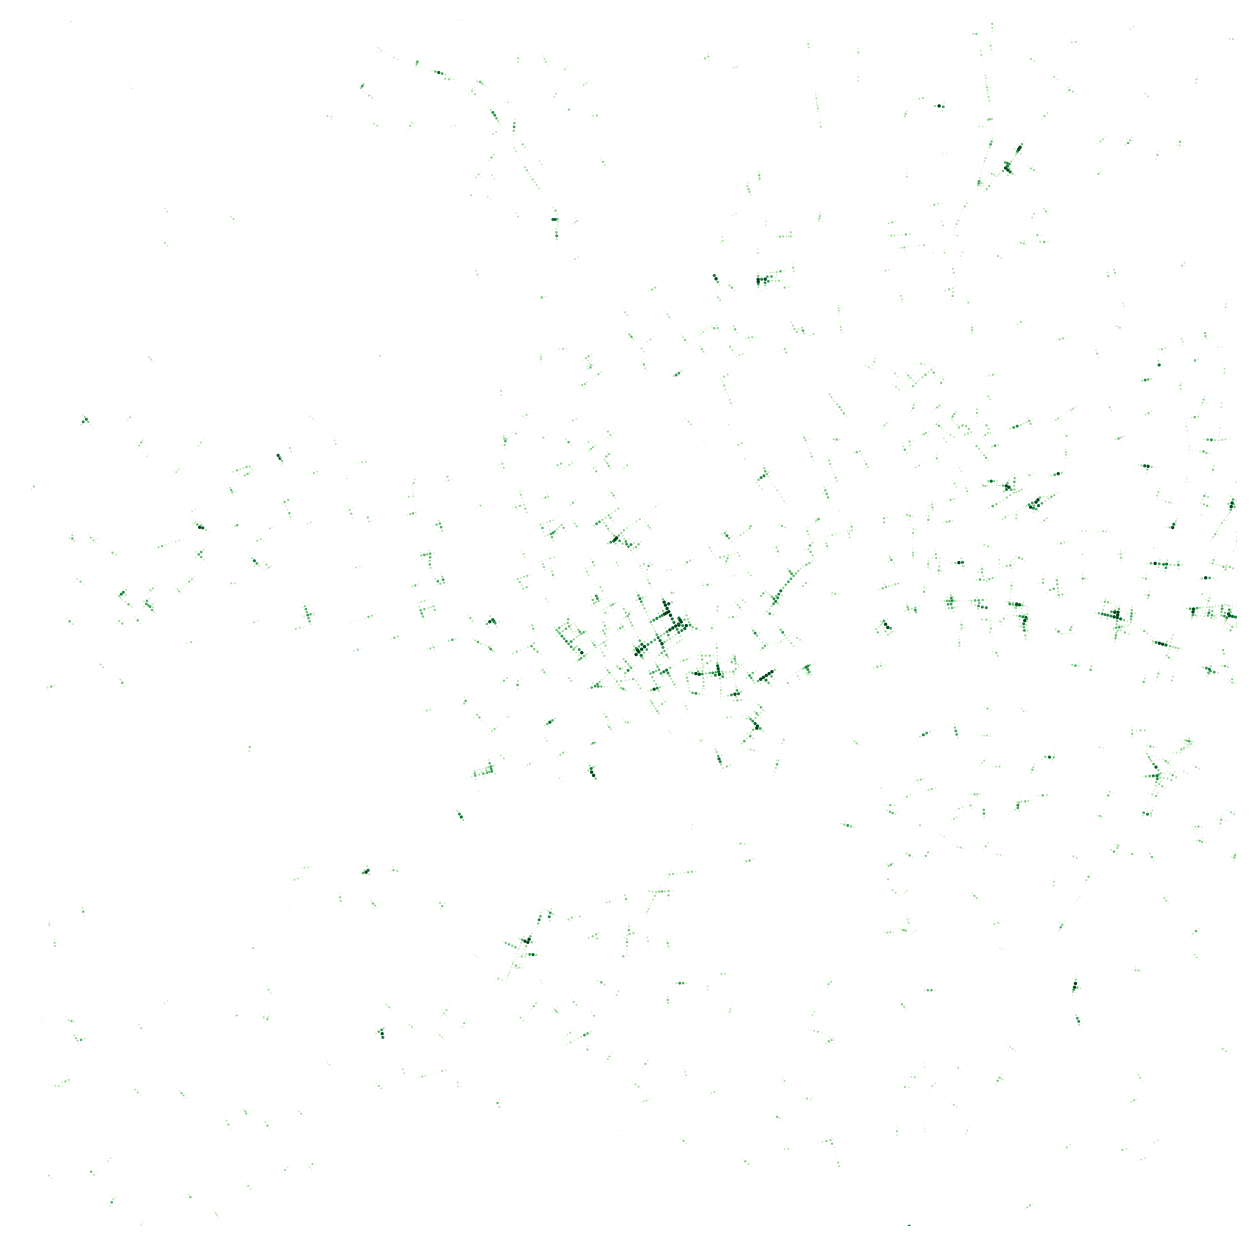


    Distance weighted Pub accessibility:
    Avg walking tolerance: 70.24m
    Beta: 0.019999999552965164 (spatial impedance factor)
    Max walking tolerance: 200m
    


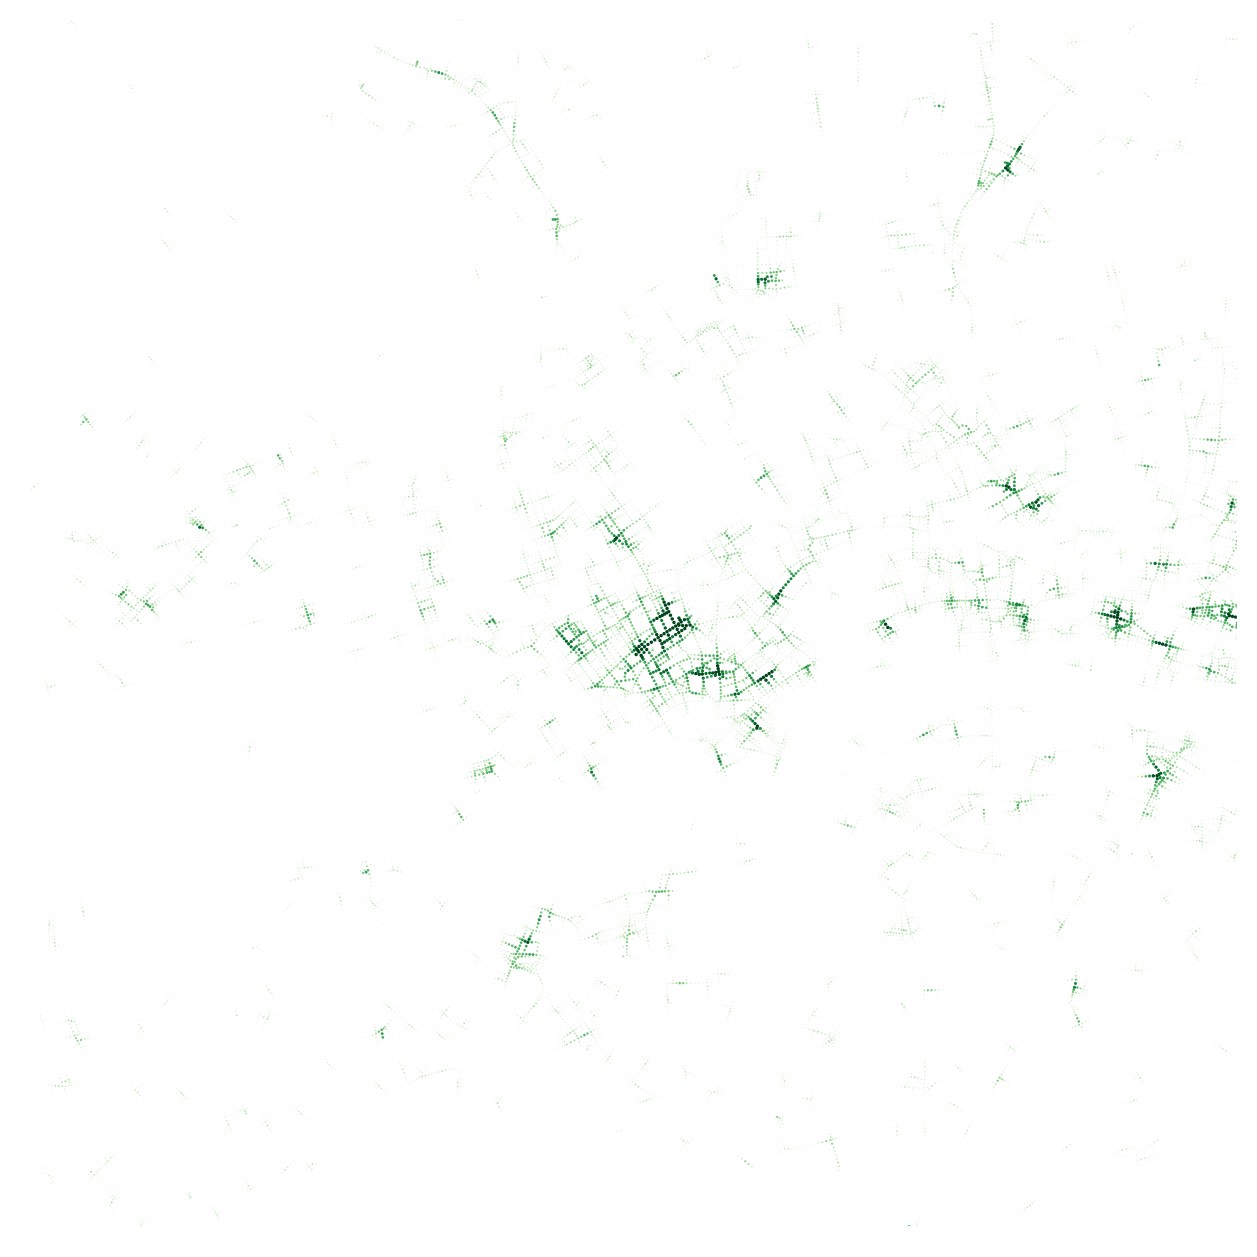


    Distance weighted Pub accessibility:
    Avg walking tolerance: 140.48m
    Beta: 0.009999999776482582 (spatial impedance factor)
    Max walking tolerance: 400m
    


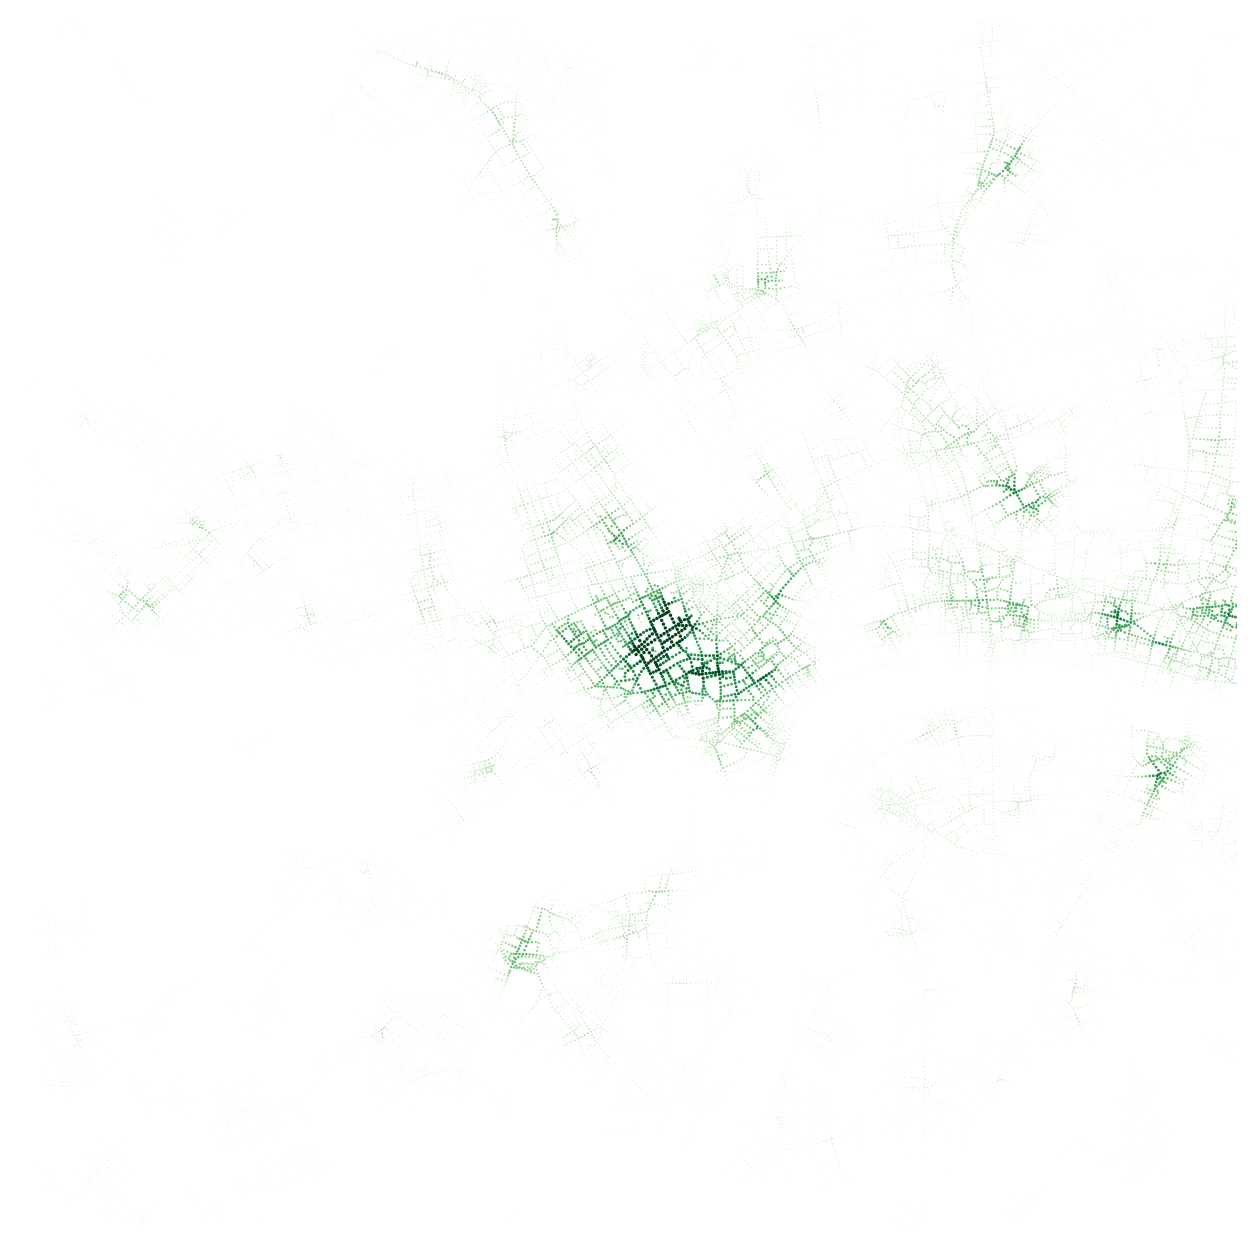


    Distance weighted Pub accessibility:
    Avg walking tolerance: 280.96m
    Beta: 0.004999999888241291 (spatial impedance factor)
    Max walking tolerance: 800m
    


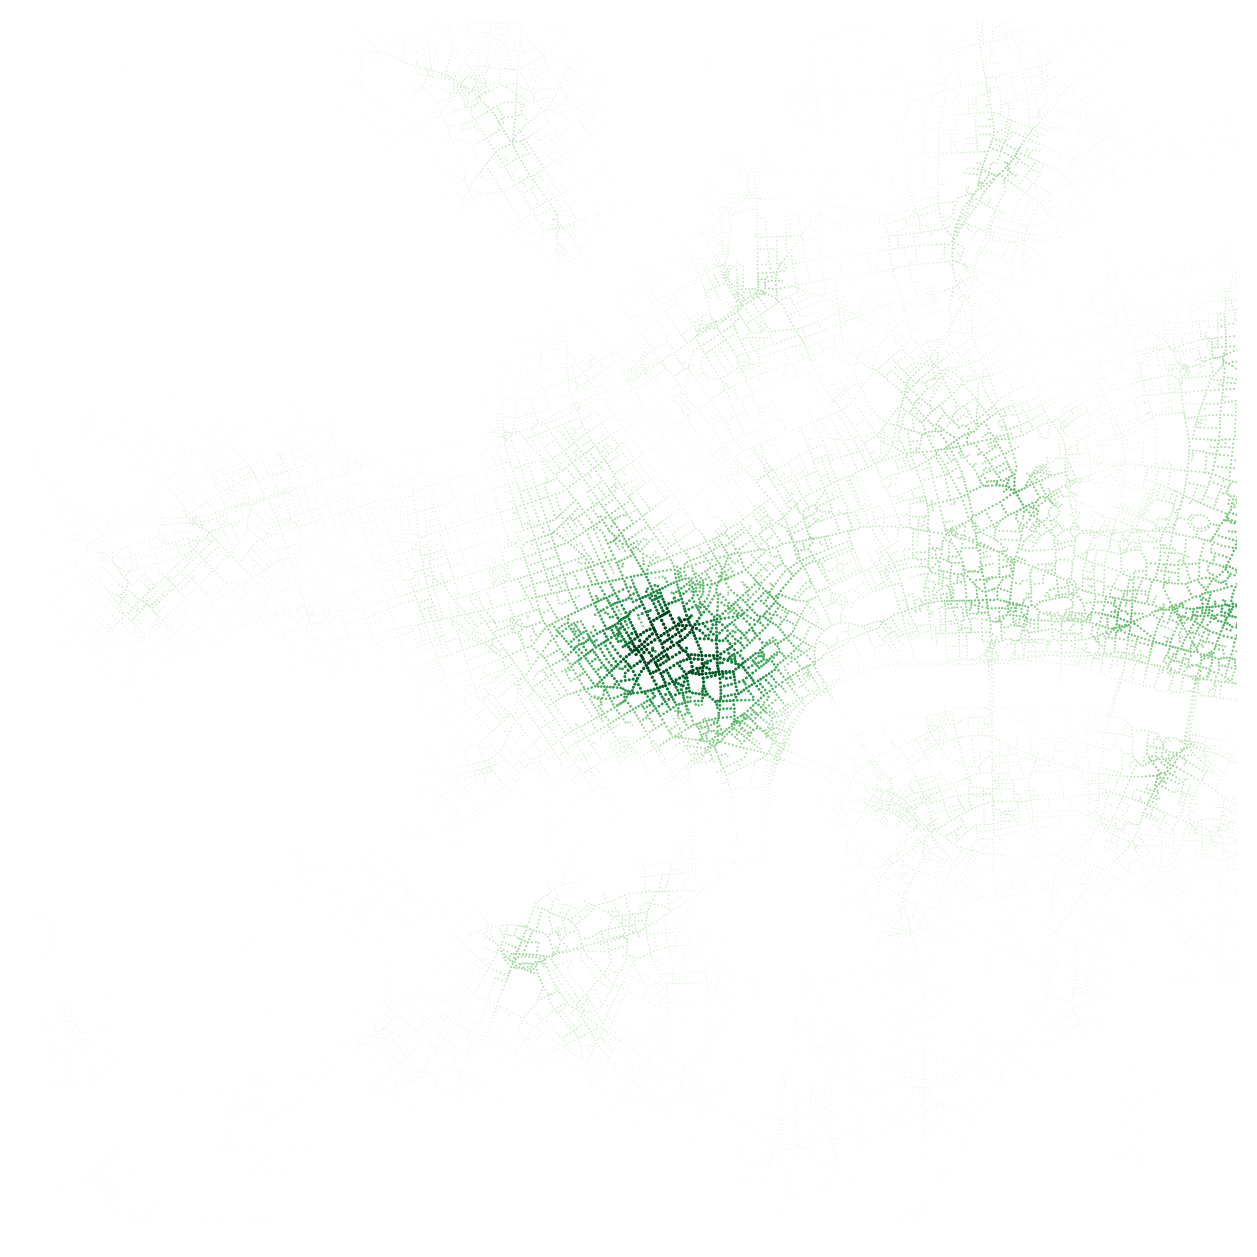

In [7]:
# data can be extracted, plotted, or otherwise manipulated directly from the numpy arrays
# see the getting started guide if you'd prefer to first convert back to NetworkX
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale


def simple_plot(xs: np.ndarray, ys: np.ndarray, vals: np.ndarray):
    """ """
    # extents
    easting, northing = utm.from_latlon(lat, lng)[:2]
    buff = geometry.Point(easting, northing).buffer(3500)
    min_x, min_y, max_x, max_y = buff.bounds
    # fig
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=200, facecolor="white")
    # filter
    select = xs > min_x
    select = np.logical_and(select, xs < max_x)
    select = np.logical_and(select, ys > min_y)
    select = np.logical_and(select, ys < max_y)
    select_idx = np.where(select)[0]
    # remove any extreme outliers
    v = np.clip(vals, np.nanpercentile(vals, 0.01), np.nanpercentile(vals, 99.9))
    # shape if wanted
    c = v**1
    c = minmax_scale(c, feature_range=(0, 1))
    s = v**1
    s = minmax_scale(s, feature_range=(0, 1.5))
    # plot
    ax.scatter(
        xs[select_idx], ys[select_idx], c=c[select_idx], s=s[select_idx], linewidths=0, edgecolors="none", cmap="Greens"
    )
    # limits
    ax.set_xlim(left=min_x, right=max_x)
    ax.set_ylim(bottom=min_y, top=max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)
    ax.set_facecolor("white")
    plt.show()


for d in [100, 200, 400, 800]:
    b = networks.beta_from_distance(d)[0]
    avg_d = networks.avg_distance_for_beta(float(b))[0]
    print(
        f"""
    Distance weighted Pub accessibility:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b} (spatial impedance factor)
    Max walking tolerance: {d}m
    """
    )
    simple_plot(
        N.network_structure.nodes.xs, N.network_structure.nodes.ys, N.metrics_state.accessibility.weighted["pub"][d]
    )